# Two-model analyzer
--------------------------------------
This analyzer uses two networks (one trained on log plots, 
the other trained on non-log plots) to make a more accurate prediction.
The average of the predictions of the models gives the new prediction.


#### Load necessary packages

In [1]:
# Load some packages

# Keras packages for network
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, Conv2D, Flatten
from keras.models import Model
from keras.optimizers import Adam, SGD
# For saving model
from keras.models import model_from_json

# Some items for plotting and drawing
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from PIL import Image
from scipy import misc
import matplotlib.pyplot as plt

# Need numpy
import numpy as np
import nn_utils as utils

%matplotlib inline

Using TensorFlow backend.


#### Load root fit data from file

In [2]:
# Load dataset
dataset = "dev"
x, y = utils.load_dataset_mysql(im_dir=dataset, log=False)
x_log, y_log = utils.load_dataset_mysql(im_dir=dataset, log=True)

# Grab dimensions of picture
(m, h, w, c) = x.shape
m_log = x_log.shape[0]
input_shape = h, w, c

# Print dimensions
print("(m, height, width, channels): (" + str(m) + ", " + str(h) + ", " + str(w) + ", " + str(c) + ")")
print("m_dev: " + str(m_log))


(m, height, width, channels): (69, 236, 348, 3)
m_dev: 69


label: bad
label: [0]


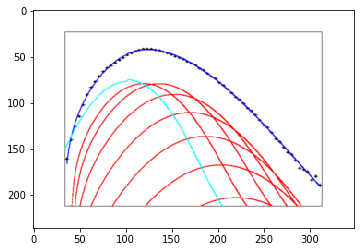

In [3]:
# Print an image
index = 25
this_image = x_log[index]
if y[index] == 1:
    print("label: good")
else:
    print("label: bad")
print("label: " + str(y[index]))
plt.imshow(np.uint8(utils.get_printable_image(this_image)))

## Define and Train 3 layer ConvNet with 2 fully connected layers plus output layer

For the convolutional layer, we will scan over our images with a certain stride and a certain kernal size. 
Each individual scan represents a single neuron in the next layer. Since each scan connects to kernal size squared
neurons below it, convolutions reduce the number of degrees of freedom. Hopefully, through learning the right filters,
we can preserve the important information as we reduce it in size.

Once the image has gone through the convolutional layers (and therefore has been reduced to its features vector), we
can send the resulting vector into some old-fashioned fully-connected layers, and finally into a logistic regression unit.

### Loadpretrained conv models

In [3]:
# load and create linear model
json_file = open('trained/conv_model_quickngood_1000epoch_sql_handlabeled.json', 'r')
conv_model_json = json_file.read()
json_file.close()
model_lin = model_from_json(conv_model_json)
model_lin.load_weights("trained/conv_model_quickngood_1000epoch_sql_handlabeled.h5")
# load and create log model
json_file = open('trained/conv_model_quickngood_1000epoch_sql_handlabeled_log.json', 'r')
conv_model_json = json_file.read()
json_file.close()
model_log = model_from_json(conv_model_json)
model_log.load_weights("trained/conv_model_quickngood_1000epoch_sql_handlabeled_log.h5")

### Compile models (print a summary)

In [4]:
# Define optimizer
#opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.001)
opt = SGD(lr=1.0, decay=1e-6, momentum=0.9, nesterov=True)
# Define loss
loss = 'mean_squared_error'
# Define metrics to use
metrics=['acc']
# Compile model
model_lin.compile(loss=loss, optimizer='sgd', metrics=metrics)
model_log.compile(loss=loss, optimizer='sgd', metrics=metrics)
# Print summary
#model_lin.summary()

### Use models to make predictions

In [5]:
# Evaluate model, get metrics back
stats_lin = model_lin.evaluate(x, y)
stats_log = model_log.evaluate(x_log, y_log)
# Calculate predictions vector from model
predictions_lin = model_lin.predict(x)
predictions_log = model_log.predict(x_log)

69/69 [==============================] - 0s 3ms/step


### Combine predictions

In [42]:
# Combine predictions, create integer prediction 0/1
predictions = np.floor(predictions_lin + predictions_log)

### Compute statistics

In [43]:
# Get vector mask for good and bad fits and right and wrong answers
good_fits = y
bad_fits = 1 - good_fits
wrong_answers = np.abs(np.subtract(predictions, good_fits))
right_answers = np.subtract(1, wrong_answers)
# Calculate true positives (tp), as well as (tn) (fp) (fn)
true_positives = np.multiply(right_answers, good_fits)
true_negatives = np.multiply(right_answers, bad_fits)
false_positives = np.multiply(wrong_answers, good_fits)
false_negatives = np.multiply(wrong_answers, bad_fits)
# Calculate additional metrics
precision = np.sum(true_positives) / np.sum(true_positives + false_positives)
recall = np.sum(true_positives) / np.sum(true_positives + false_negatives)
accuracy = np.sum(true_positives + true_negatives) / m

# Print stats
print()
print("Performance")
print(".................................................")
print("Linear Accuracy: " + str(stats_lin[1]))
print("Log Accuracy: " + str(stats_log[1]))
print(".................................................")
print("Combined Accuracy: " + str(accuracy))
print("Combined Precision: " + str(precision))
print("Combined Recall: " + str(recall))
print(".................................................")

# Print list of indices of wrong answers
bad_list = []
for i in range(m):
    if wrong_answers[i] == 1:
        bad_list.append(i)
print(".................................................")
print("List of indices of wrong guesses:")
print(bad_list)


Performance
.................................................
Linear Accuracy: 0.8985507246376812
Log Accuracy: 0.8695652173913043
.................................................
Combined Accuracy: 0.9130434782608695
Combined Precision: 0.9777777777777777
Combined Recall: 0.8979591836734694
.................................................
.................................................
List of indices of wrong guesses:
[5, 13, 42, 48, 52, 53]


### Look at an image

label: [0]
prediction: [1.]
(236, 348, 3)


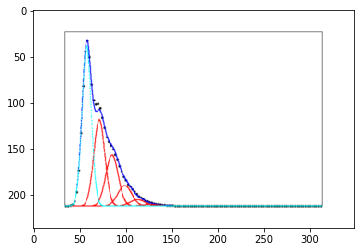

In [13]:
# Choose an index 
index = 52

# Print labels for this index
print("label: " + str(good_fits[index]))
print("prediction: " + str(predictions[index]))

# Show image
this_image = x[index]
print(str(this_image.shape))
plt.imshow(np.uint8(utils.get_printable_image(this_image)))